In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, Normalize
from ALLCools.plot import *
import re

In [3]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [4]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

In [5]:
remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

## Cell tidy data

In [6]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Tree and gene assignment

In [7]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.linkage.csv',
    header=0,
    index_col=0).reset_index(drop=True)
node_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)

gene_assignment = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/NodeGeneResults.msg'
)
gene_assignment = gene_assignment.loc[:,
                                      gene_assignment.columns.isin(keep_gene
                                                                   )].copy()
gene_assignment.columns = gene_assignment.columns.map(gene_meta['gene_name'])

In [8]:
tf_gene_assignment = gene_assignment.loc[:,
                                         gene_assignment.columns.
                                         isin(tf_gene_names)]
other_gene_assignment = gene_assignment.loc[:, ~gene_assignment.columns.
                                            isin(tf_gene_names)]

## Plot

In [18]:
top_n_tf = 5
top_n_other = 10
hard_cutoff = 0.3
max_y = 12
node_size = 20
line_space = 1.2
hue_norm = (0.3, 0.8)

In [19]:
def plot_node_gene_list(node, ax_node, ax_left_text, ax_right_text):
    # prepare data
    node_gene_values = other_gene_assignment.loc[node]
    left_hypo_other = node_gene_values[
        node_gene_values > hard_cutoff].sort_values(
            ascending=False)[:top_n_other]
    right_hypo_other = node_gene_values[node_gene_values < -hard_cutoff].abs(
    ).sort_values(ascending=False)[:top_n_other]
    node_gene_values = tf_gene_assignment.loc[node]
    left_hypo_tf = node_gene_values[
        node_gene_values > hard_cutoff].sort_values(ascending=False)[:top_n_tf]
    right_hypo_tf = node_gene_values[node_gene_values < -hard_cutoff].abs(
    ).sort_values(ascending=False)[:top_n_tf]

    left_hypo = pd.concat([left_hypo_tf, left_hypo_other])
    right_hypo = pd.concat([right_hypo_tf, right_hypo_other])
    this_node_dict = node_dict[node]

    ax = ax_node
    ax.plot((0.25, 0.25, 0.75, 0.75), (0, 1, 1, 0),
            c='gray',
            clip_on=False,
            transform=ax.transAxes)
    ax.scatter(x=(0.25, 0.5, 0.75),
               y=(0, 1, 0),
               clip_on=False,
               c=['salmon', 'gray', 'steelblue'],
               zorder=10,
               transform=ax.transAxes,
               s=node_size)
    ax.text(x=0.5,
            y=2,
            va='center',
            ha='center',
            transform=ax.transAxes,
            s=node,
            fontsize=labelsize)
    ax.axis('off')

    # max_y = (max(left_hypo.size, right_hypo.size) - 1) * line_space + 1
    cnorm = Normalize(vmin=hue_norm[0], vmax=hue_norm[1])

    ax = ax_left_text
    if left_hypo.size > 0:
        for i, (gene, value) in enumerate(left_hypo.items()):
            ax.text(0.8,
                    i * line_space,
                    gene[:10],
                    fontweight='bold' if gene in tf_gene_names else None,
                    ha='right',
                    va='center',
                    fontsize=labelsize)
            ax.scatter(0.95,
                       i * line_space,
                       s=node_size - 5,
                       clip_on=False,
                       c=[left_cmap(cnorm(value))])
        ax.set_ylim(max_y, -1)
        ax.set_xlim(0, 1)
    ax.axis('off')

    ax = ax_right_text
    if right_hypo.size > 0:
        for i, (gene, value) in enumerate(right_hypo.items()):
            ax.text(0.2,
                    i * line_space,
                    gene[:10],
                    fontweight='bold' if gene in tf_gene_names else None,
                    ha='left',
                    va='center',
                    fontsize=labelsize)
            ax.scatter(0.05,
                       i * line_space,
                       s=node_size - 5,
                       clip_on=False,
                       c=[right_cmap(cnorm(value))])
        ax.set_ylim(max_y, -1)
        ax.set_xlim(0, 1)
    ax.axis('off')


def plot_scatter(node, ax_scatter):
    # palette
    left_clusters = node_dict[node]['left']
    right_clusters = node_dict[node]['right']
    temp_palette = {}
    for cluster in cell_tidy_data['SubType'].unique():
        if cluster in left_clusters:
            temp_palette[cluster] = 'salmon'
        elif cluster in right_clusters:
            temp_palette[cluster] = 'steelblue'
        else:
            temp_palette[cluster] = 'lightgray'

    categorical_scatter(data=cell_tidy_data,
                        ax=ax_scatter,
                        coord_base='class_umap',
                        s=1,
                        hue='SubType',
                        palette=temp_palette,
                        axis_format=None)
    return

In [20]:
def get_node_path(start_node):
    int_to_cluster = {i: cluster for i, cluster in zip(dendro['leaves'], dendro['ivl'])}
    if start_node <= max(int_to_cluster.keys()):
        cluster = int_to_cluster[start_node]
    else:
        # take any child
        cluster = list(node_dict[start_node]['left'])[0]
        
    nodes = [start_node]
    for k, v in node_dict.items():
        if k < start_node:
            continue
        else:
            if cluster in (v['left'] | v['right']):
                nodes.append(k)
    node_path = sorted(set(nodes), reverse=True)
    return node_path


In [21]:
start_node = 95

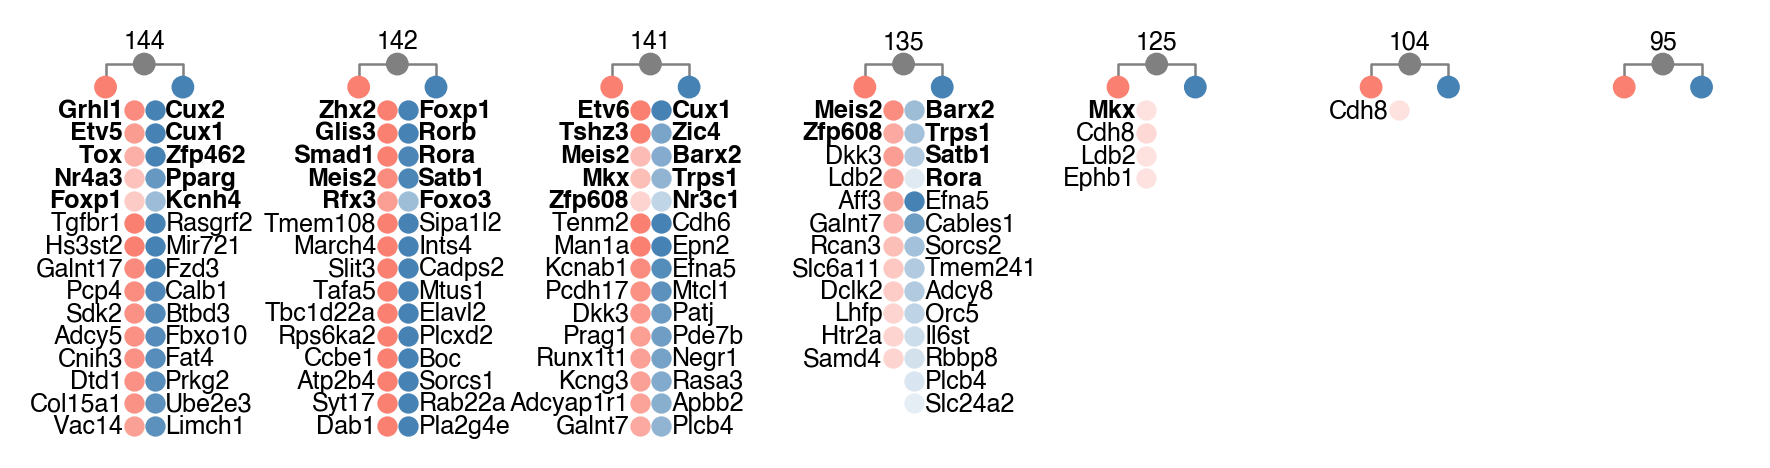

In [22]:
nodes = get_node_path(start_node)
n_nodes = len(nodes)
scale = 1.2
fig = plt.figure(figsize=(n_nodes * 0.9 * scale, 1. * scale), dpi=300)
gs = fig.add_gridspec(10, int(3*n_nodes))

left_cmap = sns.light_palette("salmon", as_cmap=True)
right_cmap = sns.light_palette("steelblue", as_cmap=True)

for i, node in enumerate(nodes):
    ax_node = fig.add_subplot(gs[0, int(3*i):int(3*i)+2])
    ax_left_text = fig.add_subplot(gs[1:10, int(3*i):int(3*i)+1])
    ax_right_text = fig.add_subplot(gs[1:10, int(3*i)+1:int(3*i)+2])
    # ax_scatter = fig.add_subplot(gs[11:16, int(3*i):int(3*i)+2])
    
    plot_node_gene_list(node, ax_node, ax_left_text, ax_right_text)
    # plot_scatter(node, ax_scatter)

fig.savefig(f'Exc.dmg_trace.node{start_node}.pdf', bbox_inches='tight')

In [ ]:
nodes = get_node_path(start_node)
n_nodes = len(nodes)
scale = 1.2
fig = plt.figure(figsize=(n_nodes * 0.9 * scale, 0.6 * scale), dpi=1200)
gs = fig.add_gridspec(10, int(3*n_nodes))

left_cmap = sns.light_palette("salmon", as_cmap=True)
right_cmap = sns.light_palette("steelblue", as_cmap=True)

for i, node in enumerate(nodes):
    ax_scatter = fig.add_subplot(gs[:, int(3*i):int(3*i)+2])
    plot_scatter(node, ax_scatter)

fig.savefig(f'Exc.dmg_trace.node{start_node}.scatter.png', bbox_inches='tight')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


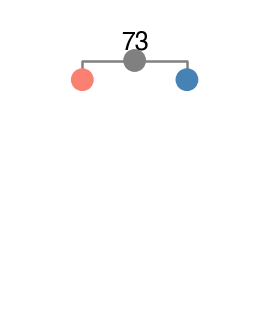

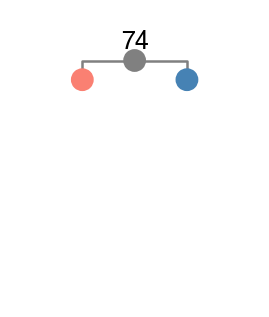

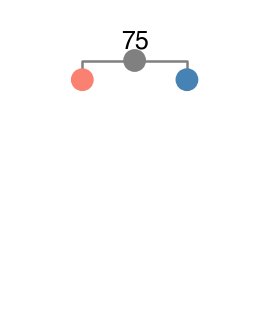

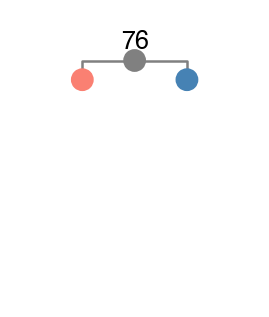

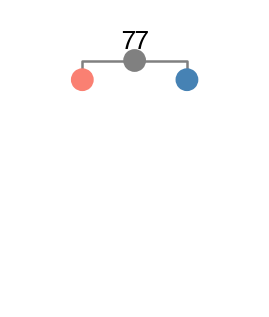

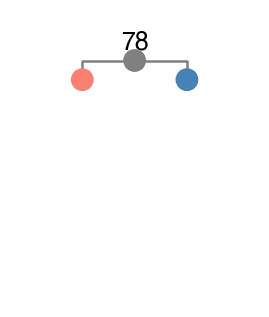

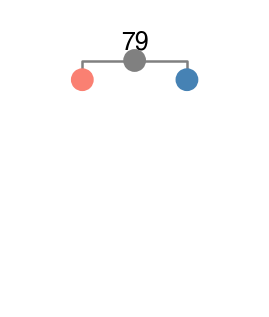

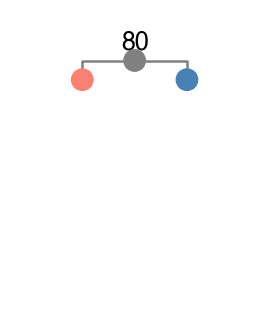

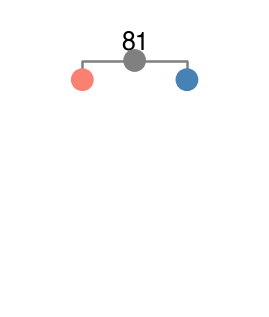

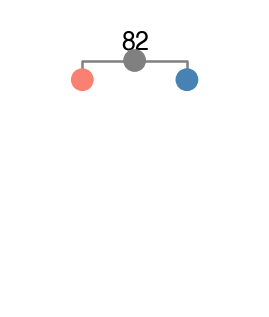

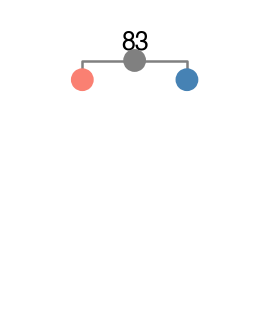

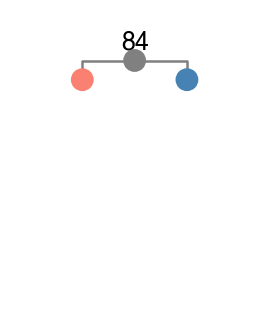

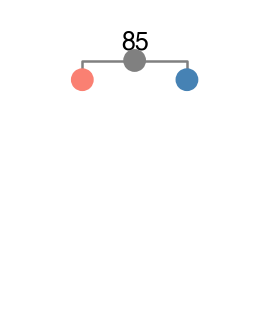

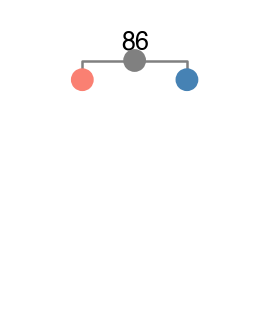

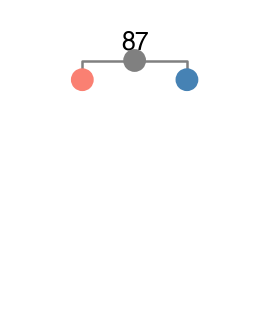

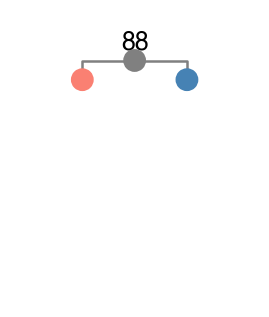

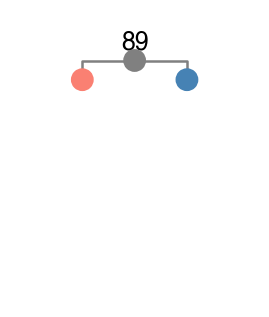

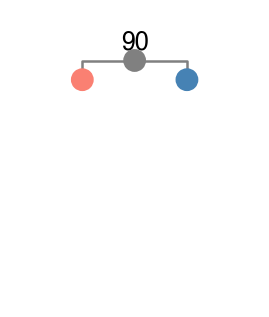

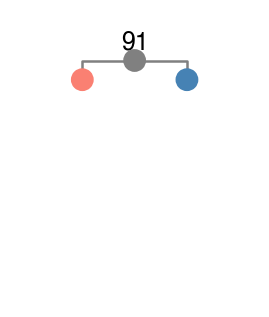

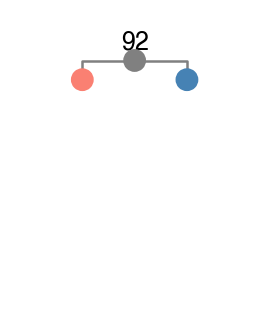

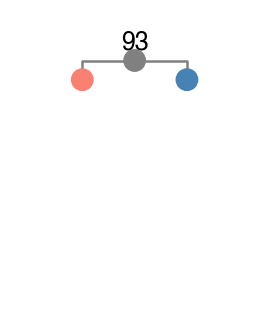

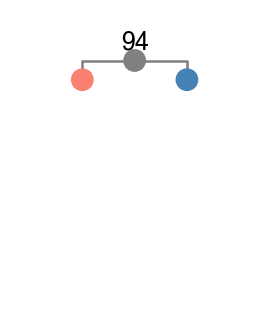

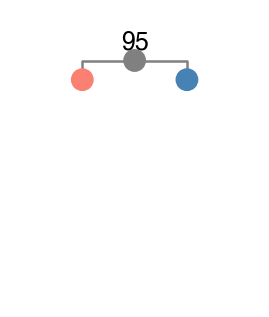

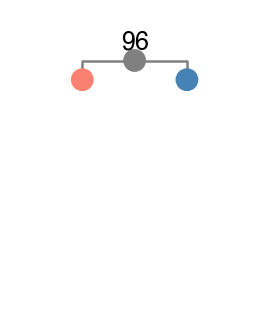

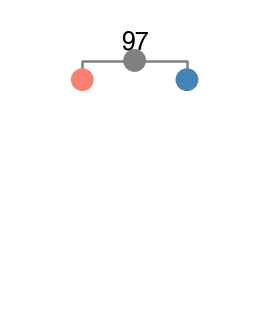

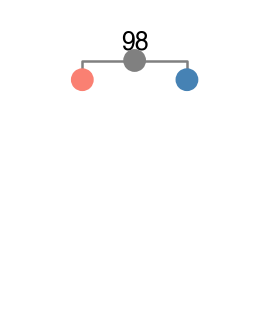

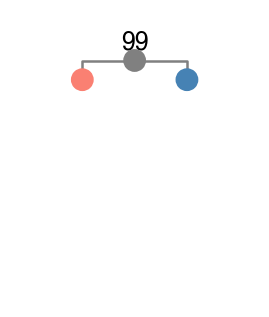

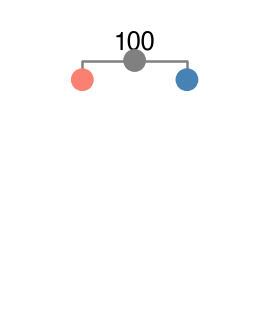

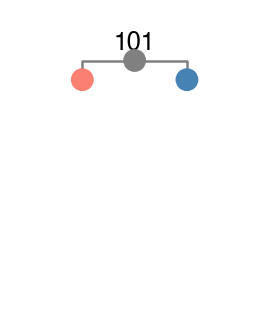

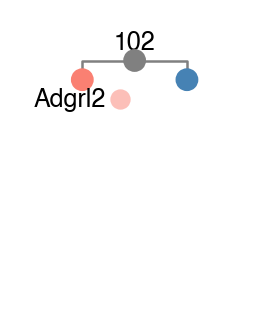

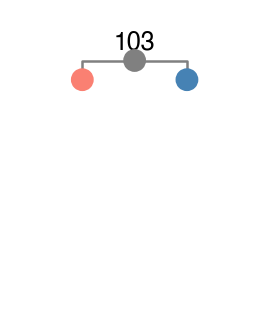

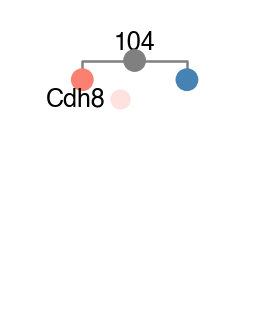

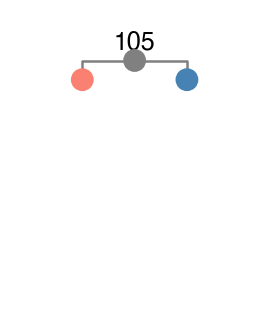

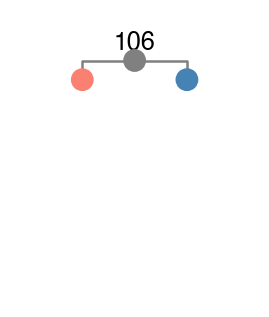

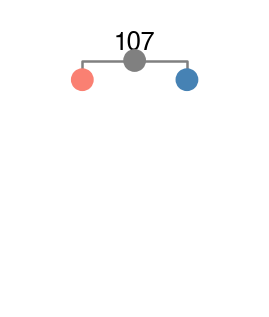

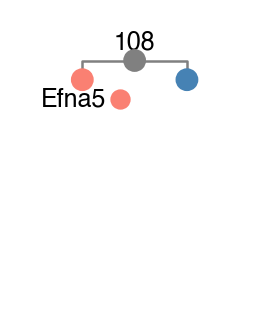

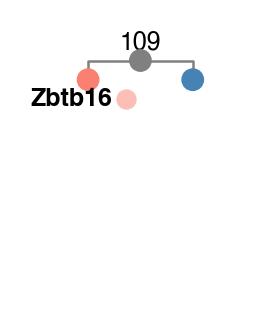

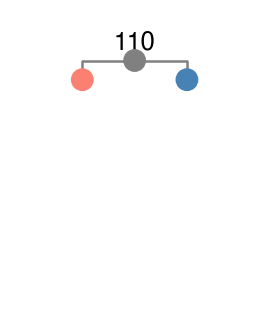

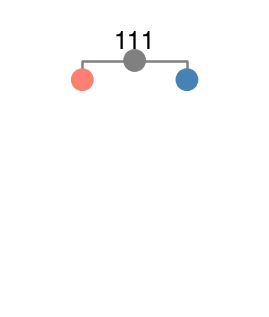

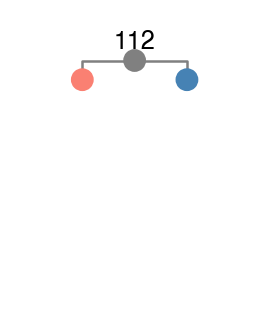

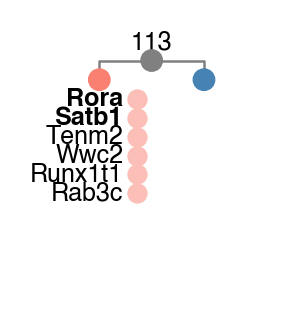

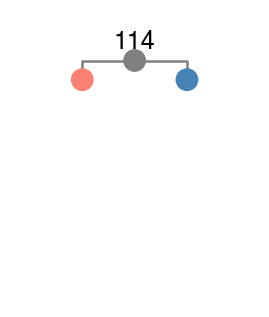

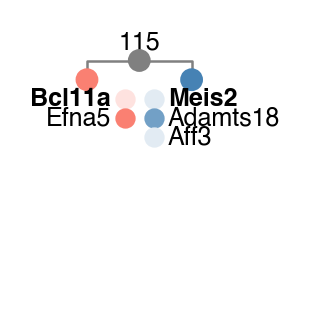

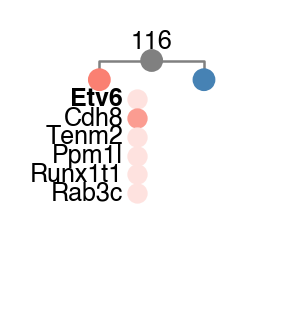

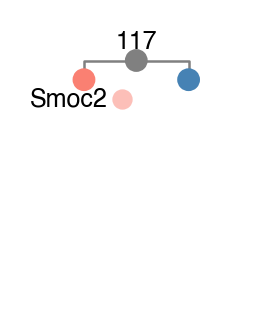

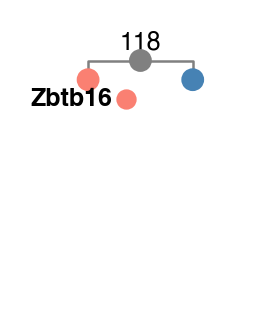

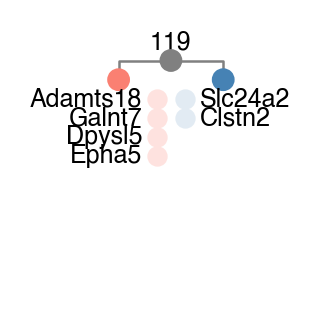

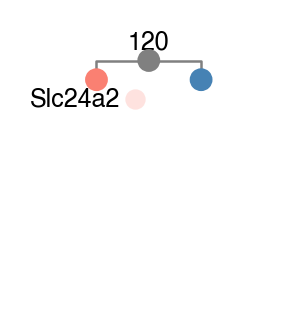

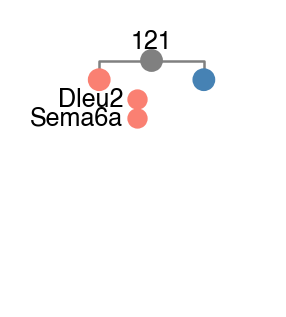

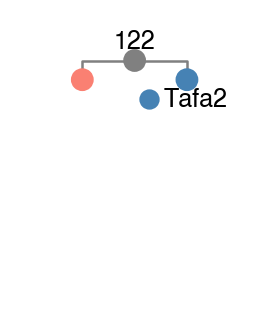

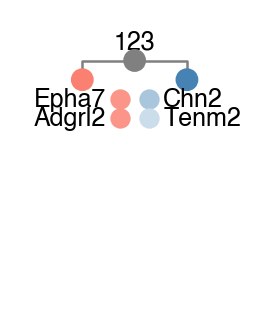

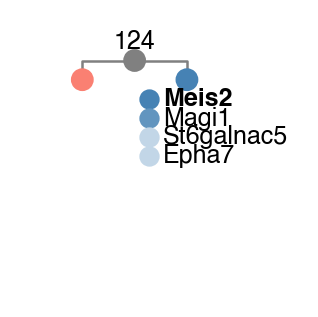

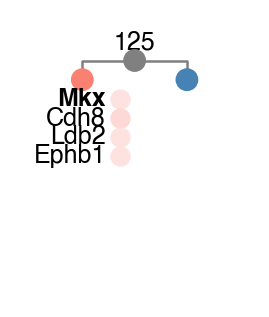

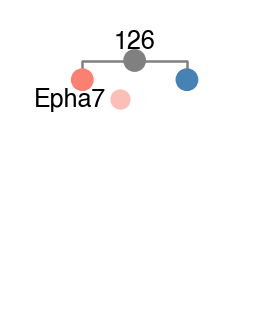

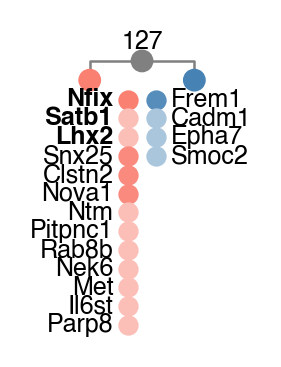

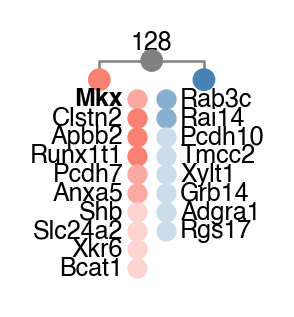

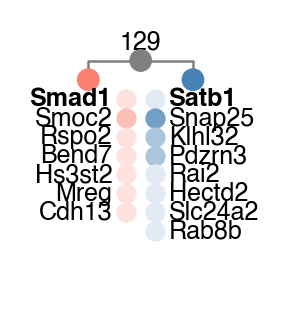

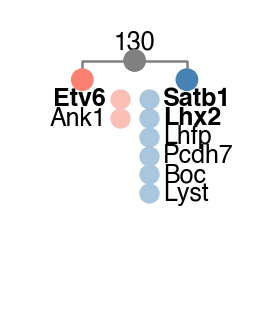

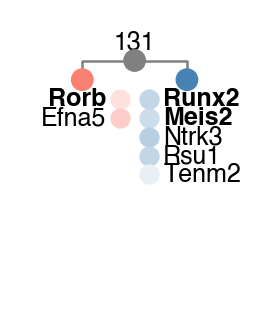

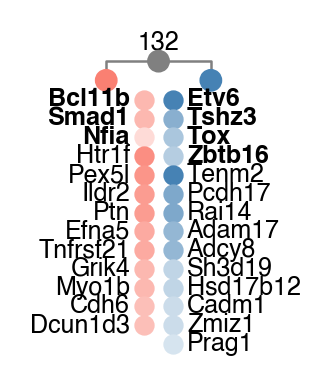

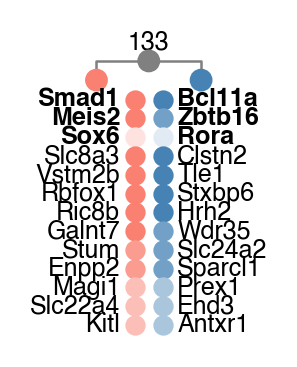

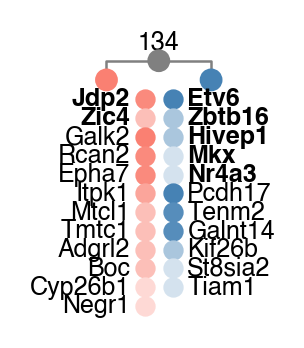

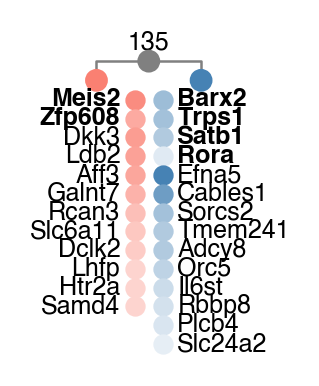

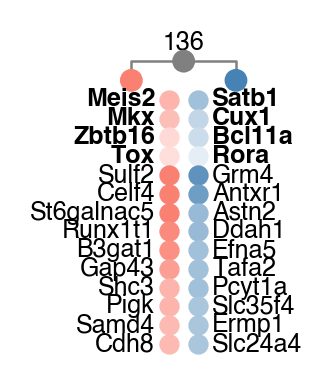

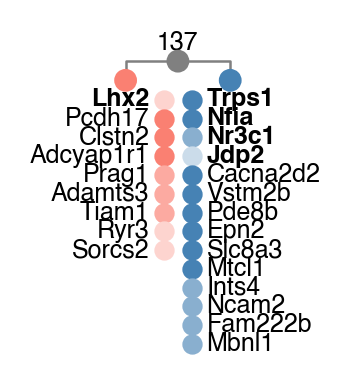

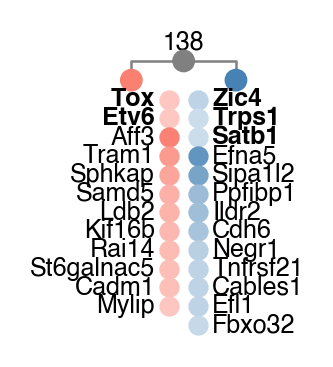

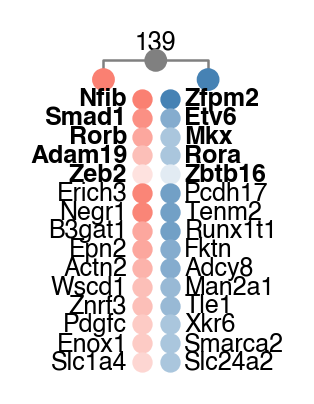

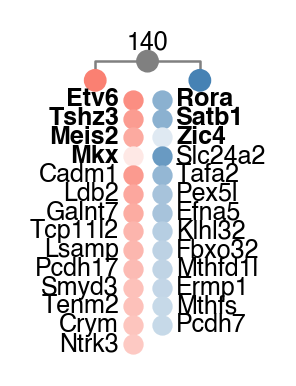

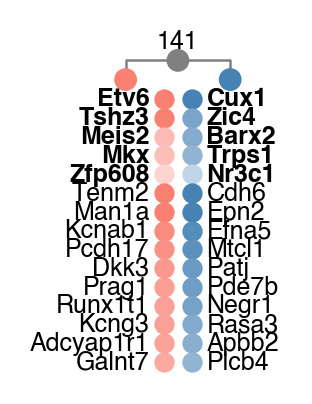

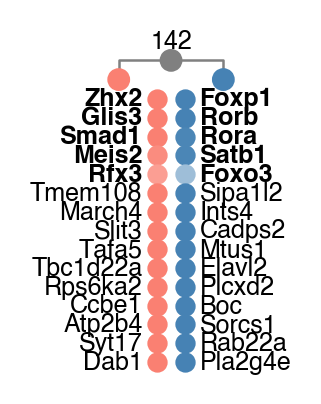

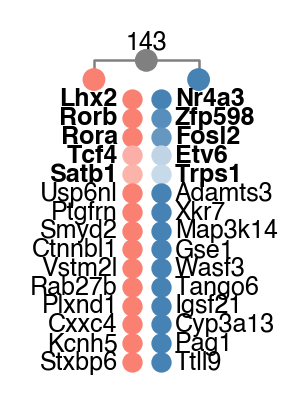

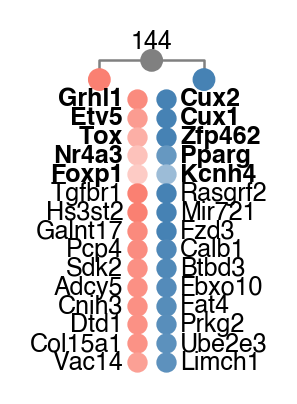

In [23]:
for node in node_dict.keys():
    fig = plt.figure(figsize=(0.9, 1), dpi=300)
    gs = fig.add_gridspec(10, 2)
    
    left_cmap = sns.light_palette("salmon", as_cmap=True)
    right_cmap = sns.light_palette("steelblue", as_cmap=True)
    ax_node = fig.add_subplot(gs[0, :2])
    ax_left_text = fig.add_subplot(gs[1:10, :1])
    ax_right_text = fig.add_subplot(gs[1:10, -1:])    
    plot_node_gene_list(node, ax_node, ax_left_text, ax_right_text)